In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import shuffle
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import f1_score
#!pip install scikit-plot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import scikitplot as skplt
import time
from sklearn import preprocessing
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from itertools import cycle


In [3]:

import seaborn as sns  # plotting
from scipy import stats


from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [4]:
dataset1 = pd.read_csv('dataset_ETC.csv')
dataset1.shape

(249742, 33)

In [5]:
dataset1 = dataset1.drop(columns=['Unnamed: 0'])

# Splitting data into train and test

train, test = train_test_split(dataset1, test_size=0.3, random_state=16)

### Models For Label Feature

In [6]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

x_train= train.iloc[:,:-2].to_numpy()
y_train= train.iloc[:,-1].to_numpy()
x_test = test.iloc[:,:-2].to_numpy()
y_test = test.iloc[:,-1].to_numpy()



# Split The Train and Test data

#x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=16)

In [7]:
def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

In [8]:
def hyperparam_tuning(clf, parameters, x, y, method='gridsearch', cv=None):
    """
    Utility function for Tuning hyperparameters
    """
    # initialization
    scoring = {'auc':'roc_auc',
               'f1':'f1',
               'FAR':make_scorer(false_alarm_rate, greater_is_better=False)}  # using custom scoring function FAR.
                
    # param tuning
    if method=='gridsearch':
        # As we are using multi scoring, So we need to point refit to scoring function with which we want to evaluate score
        tuning_clf = GridSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                  cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)
    
    elif method=='randomsearch':
        tuning_clf = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                        cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)

    return result

In [9]:
def result_visualization(tuned_clf, parameters, param1=None, param2=None,param3 = None):
    """
    Utility function to plot the results obtained after hyper parameter tuning 
    """
    # getting train and test scores to plot
    train_score = tuned_clf.cv_results_['mean_train_auc']
    test_score = tuned_clf.cv_results_['mean_test_auc']

    # print results
    print("Best Score: {}".format(tuned_clf.best_score_))
    print("Best Parameters: {}".format(tuned_clf.best_params_))

    # Want to visualize score with 2 params, plot heatmap of the 3 variables
    if param2 is not None:
        # heatmap
        train_cmap=sns.light_palette("green")
        test_cmap=sns.light_palette("blue")
        
        # Figure and axis
        fig = plt.figure(figsize=(20,5))
        train_ax = fig.add_subplot(1,2,1)
        test_ax = fig.add_subplot(1,2,2)
        
        # train heatmap
        sns.heatmap(train_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # test heapmap
        sns.heatmap(test_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=test_cmap, annot=True, fmt='.6f', ax=test_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # axis labels and plot title
        train_ax.set_title("Train hyperparam heatmap")
        train_ax.set_xlabel(param2)
        train_ax.set_ylabel(param1)

        test_ax.set_title("Test hyperparam heatmap")
        test_ax.set_xlabel(param2)
        test_ax.set_ylabel(param1)
        plt.show()
    
    
        
    
    # Want to visualize score with one param, simply plot score and param
    else:
        plt.figure(figsize=(10,5))
        plt.plot(np.log10(parameters[param1]), train_score, label="train")
        plt.plot(np.log10(parameters[param1]), test_score, label="test")

        # Plot for train data
        for i, txt in enumerate(train_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], train_score[i]))
        
        # Plot for test data
        for i, txt in enumerate(test_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], test_score[i]))
        
        plt.xlabel(param1)
        plt.ylabel('performance')
        plt.grid()
        plt.legend()
        plt.show()

In [10]:
def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """ 
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']
    
    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # auc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)
    
    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()
    
    # Returning scores of test data
    return clf, test_auc, test_f1, test_far

### Logistic Regression

#### We are starting with basic Logistic Regression for training our data.

#### Going to tune hyperparameter "alpha" and "penalty"

In [11]:
# Tuning "alpha" for l2 "penalty"
clf = SGDClassifier(loss='log', penalty='l2')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train, y_train, cv=3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=1e-06, FAR=(train=-0.011, test=-0.012), auc=(train=0.998, test=0.998), f1=(train=0.999, test=0.999), total=   0.5s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.010, test=-0.010), auc=(train=0.999, test=0.999), f1=(train=0.998, test=0.998), total=   0.5s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.012, test=-0.012), auc=(train=0.998, test=0.998), f1=(train=0.999, test=0.999), total=   0.5s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.012, test=-0.013), auc=(train=0.998, test=0.998), f1=(train=0.999, test=0.999), total=   0.3s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.012, test=-0.011), auc=(train=0.998, test=0.998), f1=(train=0.998, test=0.999), total=   0.3s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.012, test=-0.012), auc=(train=0.998, test=0.998), f1=(train=0.999, test=0.998), total=   0.3s
[CV] alpha=0.0001 ....................................................
[CV]  alpha=0.0001, FAR=(train=-0.013, test=-0.014), auc=(train=0.998, test=0.998), f1=(train=0.998, test=0.998), total=   0.2s
[CV] alpha=0.0001 ....................................................
[CV]  alp

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    9.2s finished


Best Score: 0.9983719634543428
Best Parameters: {'alpha': 1e-06}


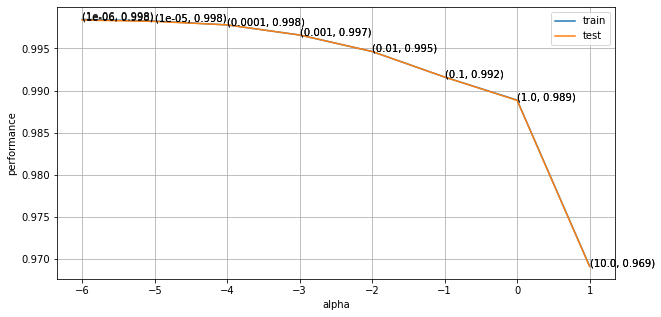

In [12]:
# Plotting the result to select best parameter
result_visualization(lr_clf, param, param1= 'alpha')

In [13]:
# Tuning "alpha" for l1 "penalty"
clf = SGDClassifier(loss='log', penalty='l1')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=1e-06, FAR=(train=-0.012, test=-0.011), auc=(train=0.999, test=0.999), f1=(train=0.998, test=0.998), total=   0.7s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.010, test=-0.010), auc=(train=0.999, test=0.999), f1=(train=0.998, test=0.998), total=   0.5s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  alpha=1e-06, FAR=(train=-0.012, test=-0.013), auc=(train=0.999, test=0.999), f1=(train=0.999, test=0.998), total=   0.6s
[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.011, test=-0.011), auc=(train=0.999, test=0.999), f1=(train=0.998, test=0.998), total=   0.6s
[CV] alpha=1e-06 .....................................................
[CV]  alpha=1e-06, FAR=(train=-0.012, test=-0.012), auc=(train=0.999, test=0.999), f1=(train=0.998, test=0.998), total=   0.7s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.010, test=-0.009), auc=(train=0.999, test=0.999), f1=(train=0.999, test=0.999), total=   0.4s
[CV] alpha=1e-05 .....................................................
[CV]  alpha=1e-05, FAR=(train=-0.010, test=-0.010), auc=(train=0.999, test=0.999), f1=(train=0.999, test=0.999), total=   0.4s
[CV] alpha=1e-05 .....................................................
[CV]  alph

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   19.8s finished


Best Score: 0.9992056292209543
Best Parameters: {'alpha': 1e-06}


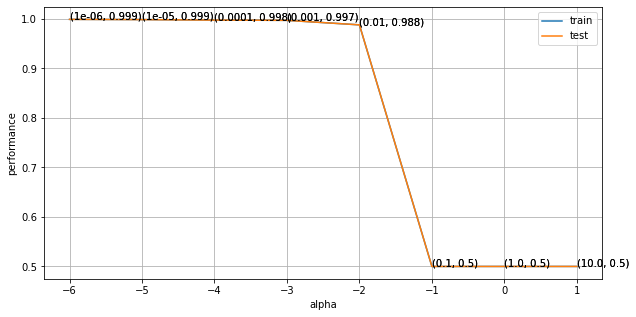

In [14]:
# Plotting alpha vs score
result_visualization(lr_clf, param, 'alpha')

In [15]:
# Best LR model
lr_bst_clf = SGDClassifier(penalty='l1', alpha=1e-6)

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   LR  | 0.9890988337241439 | 0.9985093510039958 | 0.010901166275856121 |
|   Test  |   LR  | 0.9889208362622371 | 0.9985616763406711 | 0.011079163737762864 |
+---------+-------+--------------------+--------------------+----------------------+


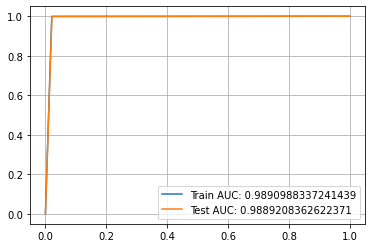

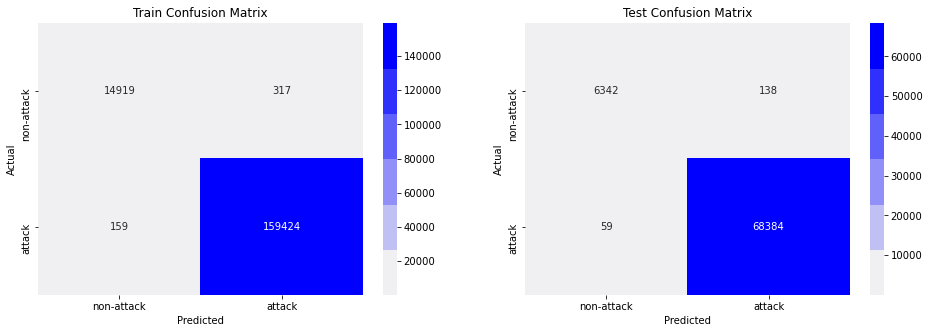

In [16]:
# Getting best model's performance on train and test data
lr_clf, lr_auc, lr_f1, lr_far = evaluate_result(lr_bst_clf, x_train, y_train, x_test, y_test, 'LR')

#### Observation

- Using wide range of values for "alpha" from 10^-6 to 10^3 and "penalty" l1 and l2
- Can observe that upto alpha=0.1 model's score is good and then its falling down heavily.
- The best parameter of the model for our data is "penalty" l1 and "alpha" 10^-6
- Both train and test auc score are very close that means model is not overfitting.
- Model is performing well but there are few False Positive points in the result

In [17]:
# An empty dictionary to store the result of all the models
result_dict = {"name":[], "auc":[], "f1":[], "far":[]}

In [18]:
# Storinig result for LR
result_dict['name'].append("LR")
result_dict['auc'].append(lr_auc)
result_dict['f1'].append(lr_f1)
result_dict['far'].append(lr_far)

In [19]:
result_dict

{'name': ['LR'],
 'auc': [0.9889208362622371],
 'f1': [0.9985616763406711],
 'far': [0.011079163737762864]}

### Linear SVC

#### The next model we are going to try is Linear Support Vector Classifier

#### Tune parameters for "alpha" and "penalty"

In [20]:
# Tuning "alpha" and "penalty"
clf = SGDClassifier(loss='hinge')
param = {'alpha':[10**x for x in range(-5,3)],  # Values for alpha
         'penalty':['l1', 'l2']}  # l1 an d l2 penalty

svm_clf = hyperparam_tuning(clf, param, x_train, y_train, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] alpha=1e-05, penalty=l1 .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.010, test=-0.010), auc=(train=0.998, test=0.998), f1=(train=0.999, test=0.999), total=   0.4s
[CV] alpha=1e-05, penalty=l1 .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.010, test=-0.010), auc=(train=0.998, test=0.998), f1=(train=0.998, test=0.998), total=   0.4s
[CV] alpha=1e-05, penalty=l1 .........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  alpha=1e-05, penalty=l1, FAR=(train=-0.010, test=-0.011), auc=(train=0.998, test=0.998), f1=(train=0.999, test=0.998), total=   0.3s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.012, test=-0.013), auc=(train=0.997, test=0.996), f1=(train=0.999, test=0.999), total=   0.2s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.012, test=-0.011), auc=(train=0.996, test=0.996), f1=(train=0.999, test=0.999), total=   0.2s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV]  alpha=1e-05, penalty=l2, FAR=(train=-0.012, test=-0.012), auc=(train=0.997, test=0.997), f1=(train=0.999, test=0.999), total=   0.2s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV]  alpha=0.0001, penalty=l1, FAR=(train=-0.012, test=-0.013), auc=(train=0.998, test=0.998), f1=(train=0.999, test=0.999), total=   0.3s
[CV] alpha=0.0001, p

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   15.8s finished


Best Score: 0.9980922207740998
Best Parameters: {'alpha': 1e-05, 'penalty': 'l1'}


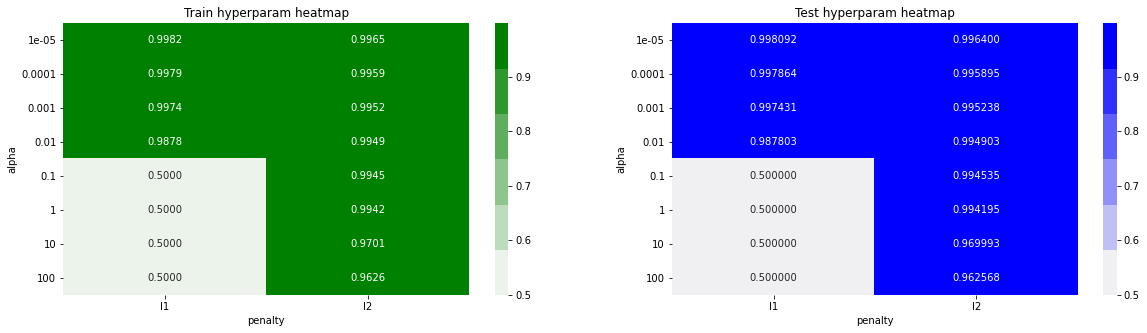

In [21]:
# Visualising scores, using heatmap to check the performance on "alpha" and "penalty"
result_visualization(svm_clf, param, 'alpha', 'penalty')

In [22]:
# Best svc model
best_svm_clf = svm_clf.best_estimator_

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |  SVM  | 0.9874634139142178 | 0.9986258877735312 | 0.01253658608578221  |
|   Test  |  SVM  | 0.9871995720328152 | 0.9986572283441583 | 0.012800427967184733 |
+---------+-------+--------------------+--------------------+----------------------+


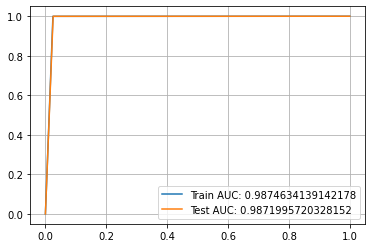

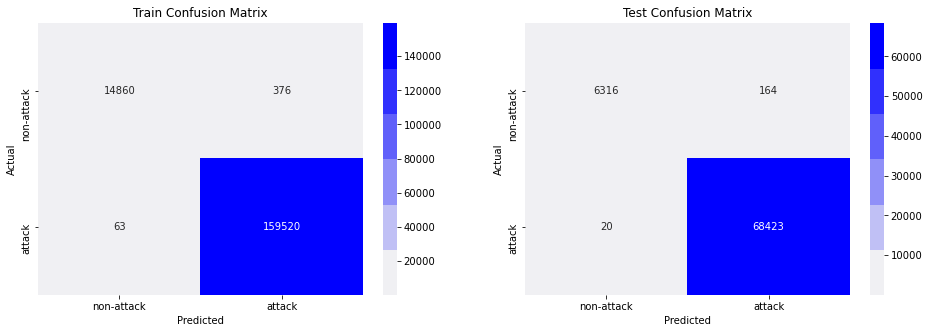

In [23]:
# Model performance on train and test
svm_clf, svm_auc, svm_f1, svm_far = evaluate_result(clf, x_train, y_train, x_test, y_test, "SVM")


### Observation

- Using wide range of "alpha" values from 10^-5 to 10^2 and l1, l2 "penalty"
- For penalty=l1 model is behaving like a random model with auc=0.5 from alpha=1 to 100.
- Best set of parameters for the model is alpha=10^-4 and penalty=l2
- Train and Test score is very close so no overfitting here, getting better value of auc and FAR tha Logistic Regression
- FAR value of this model is really good. The no of FP increased than LR but there are very few FN points in the result.


In [24]:
# Saving result of SVM
result_dict['name'].append("SVM")
result_dict['auc'].append(svm_auc)
result_dict['f1'].append(svm_f1)
result_dict['far'].append(svm_far)

### KNN
#### Tuning parameters like n_neighnors', 'weights','metric'

In [25]:
# Tuning n_neighnors', 'weights','metric'
clf = KNeighborsClassifier()
param = {'n_neighbors':[3,5,11], 
         'weights':['uniform', 'distance'], 
          'metric': ['euclidean', 'manhattan']}  

knn_clf = hyperparam_tuning(clf, param, x_train, y_train, cv=3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  metric=euclidean, n_neighbors=3, weights=uniform, FAR=(train=-0.007, test=-0.011), auc=(train=1.000, test=0.993), f1=(train=0.999, test=0.999), total= 1.2min
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=uniform, FAR=(train=-0.008, test=-0.010), auc=(train=1.000, test=0.994), f1=(train=0.999, test=0.999), total=  58.5s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.1min remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=uniform, FAR=(train=-0.008, test=-0.010), auc=(train=1.000, test=0.993), f1=(train=0.999, test=0.999), total= 1.1min
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, FAR=(train=-0.001, test=-0.011), auc=(train=1.000, test=0.992), f1=(train=1.000, test=0.999), total= 1.2min
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, FAR=(train=-0.001, test=-0.009), auc=(train=1.000, test=0.993), f1=(train=1.000, test=0.999), total=  57.0s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, FAR=(train=-0.001, test=-0.010), auc=(train=1.000, test=0.993), f1=(train=1.000, test=0.999), total= 1.0min
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV]  metric=euclidean, n_neighbors=5, weights=uniform, F

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 192.0min finished


Best Score: 0.9968305839682263
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


ValueError: cannot reshape array of size 12 into shape (3,2)

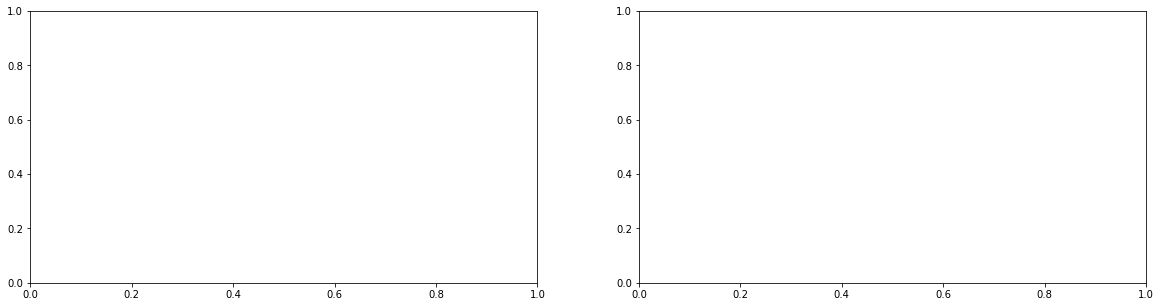

In [28]:
# Visualising scores, using heatmap to check the performance on neighbors,metric, and weights
result_visualization(knn_clf, param, 'n_neighbors', 'weights','metric')

In [29]:
# Best knn model
best_knn_clf = knn_clf.best_estimator_

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |  KNN  | 0.9910406307165932 | 0.9990262779710263 | 0.008959369283406746 |
|   Test  |  KNN  | 0.9897499753331735 | 0.9988319974303943 | 0.010250024666826481 |
+---------+-------+--------------------+--------------------+----------------------+


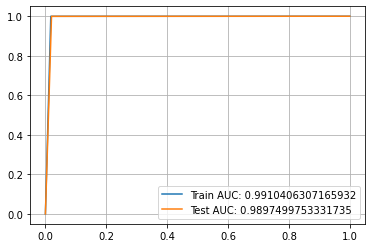

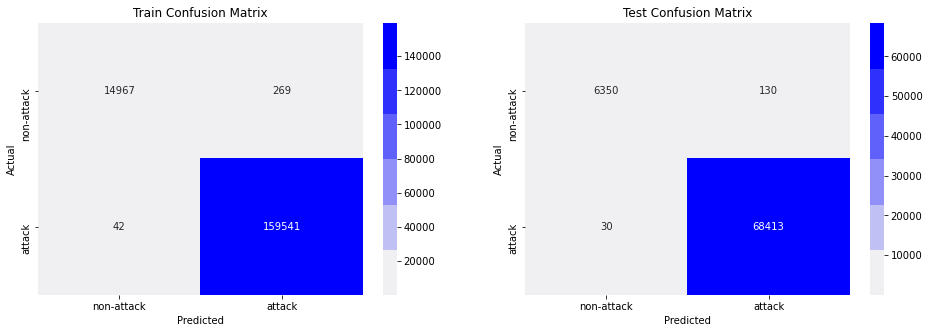

In [30]:
# Model performance on train and test
knn_clf, knn_auc, knn_f1, knn_far = evaluate_result(clf, x_train, y_train, x_test, y_test, "KNN")


In [42]:
# Saving result of KNN
result_dict['name'].append("KNN")
result_dict['auc'].append(knn_auc)
result_dict['f1'].append(knn_f1)
result_dict['far'].append(knn_far)

### Naive Bayes Model

In [34]:

clf = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9, num=100)} 

nb_clf = hyperparam_tuning(clf, param, x_train, y_train, cv=3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  var_smoothing=1.0, FAR=(train=-0.065, test=-0.065), auc=(train=0.991, test=0.990), f1=(train=0.939, test=0.940), total=   0.1s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  var_smoothing=1.0, FAR=(train=-0.065, test=-0.064), auc=(train=0.990, test=0.991), f1=(train=0.940, test=0.939), total=   0.1s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  var_smoothing=1.0, FAR=(train=-0.064, test=-0.065), auc=(train=0.991, test=0.991), f1=(train=0.940, test=0.940), total=   0.1s
[CV] var_smoothing=0.8111308307896871 ................................
[CV]  var_smoothing=0.8111308307896871, FAR=(train=-0.065, test=-0.065), auc=(train=0.991, test=0.990), f1=(train=0.939, test=0.940), total=   0.1s
[CV] var_smoothing=0.8111308307896871 ................................
[CV]  var_smoothing=0.8111308307896871, FAR=(train=-0.065, test=-0.065), auc=(train=0.990, test=0.991), f1=(train=0.939, test=0.939), total=   0.1s
[CV] var_smoothing=0.8111308307896871 ................................
[CV]  var_smoothing=0.8111308307896871, FAR=(train=-0.065, test=-0.065), auc=(train=0.991, test=0.991), f1=(train=0.939, test=0.939), total=   0.1s
[CV] var_smoothing=0.657933224657568 .................................
[CV]  var_smoothing=0.657933224657568, FAR=(train=-0.065, test=-0.065), auc=(train=0.991, test=0.990), f1=(train=0.939, test=0.939), total=

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.1min finished


Best Score: 0.9907351334882067
Best Parameters: {'var_smoothing': 0.2848035868435802}


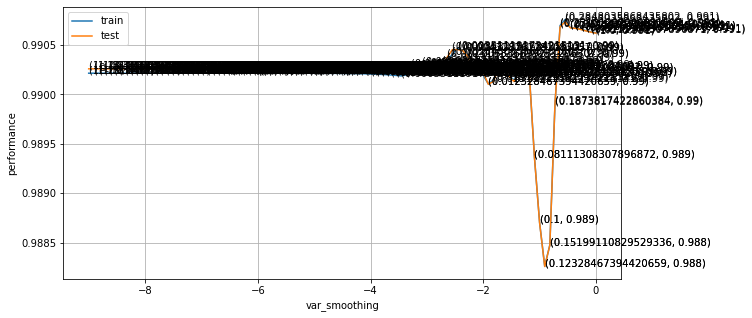

In [35]:
# Visualising scores, using heatmap to check the performance parameters
result_visualization(nb_clf, param, 'var_smoothing')

In [36]:
# Best Naive Bayes model
best_knn_clf = nb_clf.best_estimator_

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   NB  | 0.9828600275224723 | 0.9925565191095543 | 0.017139972477527892 |
|   Test  |   NB  | 0.9820962953673444 | 0.9924646366721015 | 0.017903704632655486 |
+---------+-------+--------------------+--------------------+----------------------+


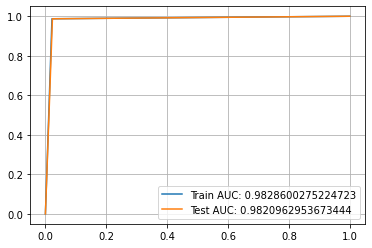

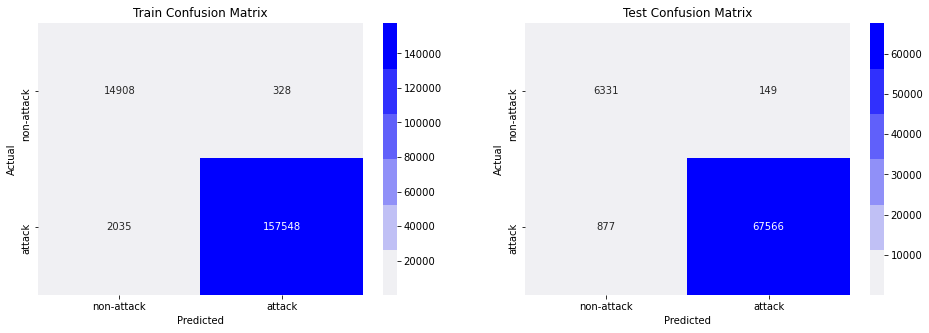

In [37]:
# Model performance on train and test
nb_clf,nb_auc, nb_f1,nb_far = evaluate_result(clf, x_train, y_train, x_test, y_test, "NB")


In [40]:
# Saving result of NB
result_dict['name'].append("NB")
result_dict['auc'].append(nb_auc)
result_dict['f1'].append(nb_f1)
result_dict['far'].append(nb_far)

In [41]:
pd.DataFrame(result_dict)

,name,auc,f1,far
0,LR,0.988921,0.998562,0.011079
1,SVM,0.987200,0.998657,0.012800
2,KNN,0.989750,0.998832,0.010250
3,KNN,0.989750,0.998832,0.010250
4,NB,0.982096,0.992465,0.017904
5,NB,0.982096,0.992465,0.017904


### Ensembles
#### Voting Classifier Model
Trining a ensemble model using voting classifier, Taking 2 classifiers LogisticRegression, SVM



In [45]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
# Initializing all the 3 classifiers with best found parameters


knn_clf = KNeighborsClassifier( metric = 'manhattan', n_neighbors=11, weights= 'uniform')

nb_clf = GaussianNB(priors=None, var_smoothing = 0.2848035868435802)



+---------+------------+--------------------+--------------------+----------------------+
| Dataset |   Model    |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+------------+--------------------+--------------------+----------------------+
|  Train  | Voting Clf | 0.9890698926575419 | 0.9964840242853465 | 0.010930107342458185 |
|   Test  | Voting Clf | 0.9857790999106584 | 0.9960406618900899 | 0.014220900089341713 |
+---------+------------+--------------------+--------------------+----------------------+


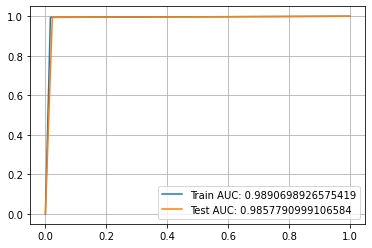

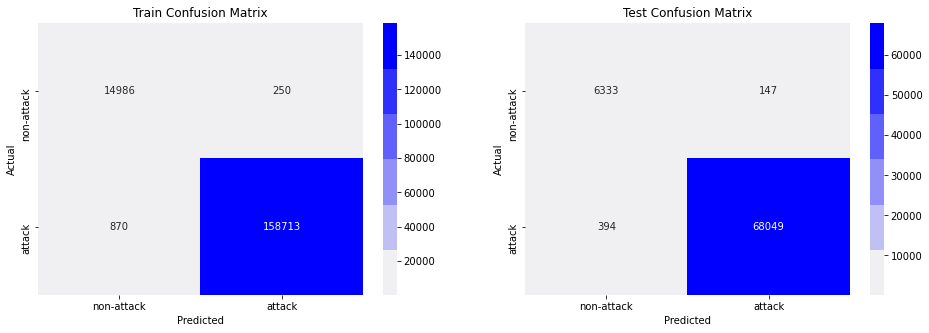

In [46]:
# Result with voting classifier
v_clf = VotingClassifier(estimators=[('knn', knn_clf),('nb', nb_clf)], voting='soft', n_jobs=-1)
v_clf, v_auc, v_f1, v_far = evaluate_result(v_clf, x_train, y_train, x_test, y_test, "Voting Clf")
print()

In [53]:
for i,j in zip(result_dict.keys(), ["Voting", v_auc, v_f1, v_far]):
    result_dict[i].append(j)

pd.DataFrame(result_dict)


,name,auc,f1,far
0,LR,0.988921,0.998562,0.011079
1,SVM,0.987200,0.998657,0.012800
2,KNN,0.989750,0.998832,0.010250
3,KNN,0.989750,0.998832,0.010250
4,NB,0.982096,0.992465,0.017904
5,NB,0.982096,0.992465,0.017904
6,KNN,0.989750,0.998832,0.010250
7,Voting,0.985779,0.996041,0.014221
8,Voting,0.985779,0.996041,0.014221


### Observations

- Training this model using 2 model best KNN and best NB.
- The auc score of this model is higher than models SVM and Logistic Regression.
- There is a gap in train and test auc and higher gap in train and test f1 and FAR
- In train the FAR is very very low but in test there are still few FP and FN and they are almost equal in number


In [48]:
best_model = KNeighborsClassifier( metric = 'manhattan', n_neighbors=11, weights= 'distance')
best_model.fit(x_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')

In [49]:
best_model_score = f1_score(y_test, best_model.predict(x_test))
print("The best model (KNN) F1 score is = ", best_model_score )

The best model (KNN) F1 score is =  0.9987003694455395


### Models for Multiclass and using the hyperparameters from Binary Classification(label)

In [50]:
X=[]
y=[]
X = dataset1.iloc[:,:-2].to_numpy()
y = dataset1.iloc[:,-2].to_numpy()


In [54]:
def plot_roc(y_pred_val, y_testlb_val, y_predlb_val, classifier,count):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(np.unique(y_pred_val))):
    fpr[i], tpr[i], _ = roc_curve(y_testlb_val[:, i], y_predlb_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  n_classes = len(np.unique(y_pred_val))
  print('n_classes',n_classes)
  print('fpr[i] ',fpr[i])
  print('tpr[i] ',tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Plot all ROC curves
  plt.figure()
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristics '+classifier)
  plt.legend(loc="lower right")
  plt.savefig('ROC '+classifier+' '+str(count)+'.png')
  plt.show()
  plt.clf()

### KNN MODEL

TRAIN: [     1      3      4 ... 249738 249739 249741] 
 TEST: [     0      2     24 ... 249729 249736 249740] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [0 1 2 3 4 5 6 7 8 9] 

shape pred 
 (49949, 10) 

shape test 
 (49949, 11) 

ROC SCORE:
 0.7150603205359467 

F1 SCORE:
 0.9844241125948467 

n_classes 10
fpr[i]  [0.00000000e+00 1.60269252e-04 1.00000000e+00]
tpr[i]  [0.         0.12121212 1.        ]


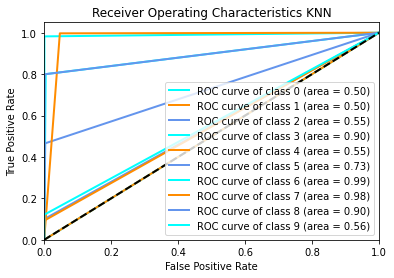

TRAIN: [     0      2      3 ... 249736 249738 249740] 
 TEST: [     1      8     19 ... 249737 249739 249741] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [0 2 3 4 5 6 7 8 9] 

shape pred 
 (49949, 9) 

shape test 
 (49949, 11) 

ROC SCORE:
 0.45096633457553587 

F1 SCORE:
 0.9845041942781637 

n_classes 9
fpr[i]  [0.0000000e+00 3.0206005e-04 1.0000000e+00]
tpr[i]  [0.         0.00689655 1.        ]


<Figure size 432x288 with 0 Axes>

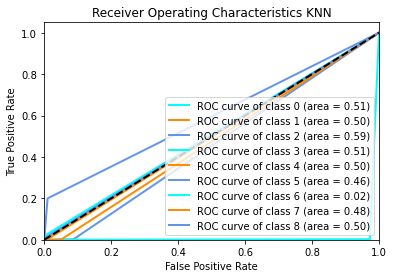

TRAIN: [     0      1      2 ... 249739 249740 249741] 
 TEST: [     4      6      9 ... 249710 249724 249726] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 0  1  2  3  4  5  6  7  8  9 10] 

shape pred 
 (49948, 11) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.7130967239152995 

F1 SCORE:
 0.9836429887082566 

n_classes 11
fpr[i]  [0. 0. 1.]
tpr[i]  [0.         0.16666667 1.        ]


<Figure size 432x288 with 0 Axes>

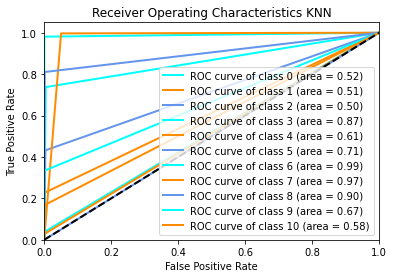

TRAIN: [     0      1      2 ... 249739 249740 249741] 
 TEST: [     3     18     28 ... 249728 249732 249735] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 0  1  2  3  4  5  6  7  8  9 10] 

shape pred 
 (49948, 11) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.7232755071267575 

F1 SCORE:
 0.984003363498038 

n_classes 11
fpr[i]  [0. 0. 1.]
tpr[i]  [0.         0.16666667 1.        ]


<Figure size 432x288 with 0 Axes>

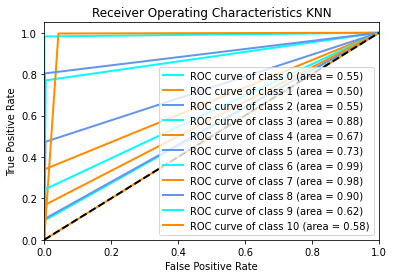

TRAIN: [     0      1      2 ... 249739 249740 249741] 
 TEST: [     5      7     11 ... 249733 249734 249738] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 0  1  2  3  4  5  6  7  8  9 10] 

shape pred 
 (49948, 11) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.7068944268143263 

F1 SCORE:
 0.984123488427965 

n_classes 11
fpr[i]  [0.00000000e+00 4.00464539e-05 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

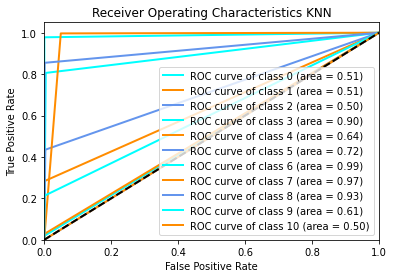

F1 score for KNN model prediction:  
 [0.9844241125948467, 0.9845041942781637, 0.9836429887082566, 0.984003363498038, 0.984123488427965] 

Avg F1 score 0.9841396295014541 

Accuracy score for KNN prediction:  
 [0.7150603205359467, 0.45096633457553587, 0.7130967239152995, 0.7232755071267575, 0.7068944268143263] 

Avg cv score 0.6618586625935732 

Time taken by KNN model:  95.89521839999979 seconds 



<Figure size 432x288 with 0 Axes>

In [55]:
skf = StratifiedKFold(n_splits=5,shuffle = True)
#   Training Model with KNN and evluate with F1 and ROC metrics:


time_knn =[]
f1_knn = []
roc_knn = []


for train_index, test_index in skf.split(X, y):
    count = 0
    print("TRAIN:", train_index,'\n', "TEST:", test_index,'\n')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Y_train:",np.unique(y_train),'\n')
    print("Y_test unique: ",np.unique(y_test),'\n')
    s = time.process_time()
    knn_model =  KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights= 'uniform')
    knn_model.fit(X_train,y_train)

    y_pred = knn_model.predict(X_test)
    print('ypred unique \n',np.unique(y_pred),'\n')
    e = time.process_time() - s
    time_knn.append(e)
    lb = preprocessing.LabelBinarizer()
    y_testlb = lb.fit_transform(y_test)
    y_predlb = lb.fit_transform(y_pred)

    print('shape pred \n',y_predlb.shape,'\n')
    print('shape test \n',y_testlb.shape,'\n')

    roc_score = roc_auc_score(y_testlb,y_predlb)
    print('ROC SCORE:\n',roc_score,'\n') 
    roc_knn.append(roc_score)

    f1score = f1_score(y_test, y_pred, average='micro')
    print('F1 SCORE:\n',f1score,'\n')
    f1_knn.append(f1score)

    plot_roc(y_pred, y_testlb, y_predlb, "KNN",count)
    count+=1

f1_knn_avg = np.mean(f1_knn)
roc_knn_avg = np.mean(roc_knn)
print("F1 score for KNN model prediction: ",'\n',f1_knn,'\n')
print("Avg F1 score",f1_knn_avg,'\n')
print("Accuracy score for KNN prediction: ",'\n',roc_knn,'\n')
print("Avg cv score",roc_knn_avg,'\n')
print("Time taken by KNN model: ", (sum(time_knn)/5),"seconds \n")
      

### Naive Bayes Model

In [56]:
skf = StratifiedKFold(n_splits=5,shuffle = True)
time_nv =[]
f1_nv = []
roc_nv = []


# Training Model with Navie Bayes and evalauting using F1 and ROC accuracy

for train_index, test_index in skf.split(X, y):
     count = 0
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.process_time()
     NB_model = GaussianNB(priors=None, var_smoothing=0.2848035868435802)
     NB_model.fit(X_train,y_train)
     y_pred = NB_model.predict(X_test)

     e = time.process_time() - s
     time_nv.append(e) 
     score = f1_score(y_test,y_pred, average='micro')
     f1_nv.append(score)

     lb = preprocessing.LabelBinarizer()
     y_testlb = lb.fit_transform(y_test)
     y_predlb = lb.fit_transform(y_pred)

     accuracy = roc_auc_score(y_testlb,y_predlb)
     roc_nv.append(accuracy)
    #  plot_roc(y_pred, y_testlb, y_predlb, "Navie Bayes",count)
    #  count+=1


f1_nv_avg = np.mean(f1_nv)
roc_nv_avg = np.mean(roc_nv)
time_nv_avg = (sum(time_nv)/5)
print("F1 score for NB Gaussian model prediction: ",'\n',f1_nv,'\n')
print("Avg F1 score",f1_nv_avg,'\n')
print("Accuracy score for NB Gaussian model prediction: ",'\n',roc_nv,'\n')
print("Avg cv score",roc_nv_avg,'\n')
print("Time taken by NB Gaussian model: ", (sum(time_nv)/5),"seconds \n")

TRAIN: [     0      1      2 ... 249737 249739 249741] TEST: [     8     11     15 ... 249728 249738 249740]
TRAIN: [     0      1      2 ... 249738 249739 249740] TEST: [     6     21     28 ... 249733 249735 249741]
TRAIN: [     1      3      4 ... 249739 249740 249741] TEST: [     0      2      5 ... 249734 249736 249737]
TRAIN: [     0      1      2 ... 249738 249740 249741] TEST: [     9     10     12 ... 249723 249724 249739]
TRAIN: [     0      2      5 ... 249739 249740 249741] TEST: [     1      3      4 ... 249729 249731 249732]
F1 score for NB Gaussian model prediction:  
 [0.8787963722997457, 0.8799175158661835, 0.8764314887482982, 0.8811764234804197, 0.8806959237607112] 

Avg F1 score 0.8794035448310715 

Accuracy score for NB Gaussian model prediction:  
 [0.4561444448437714, 0.45758509424090604, 0.46110756453181345, 0.45739739210395414, 0.4563135424110444] 

Avg cv score 0.4577096076262978 

Time taken by NB Gaussian model:  0.09509260000013456 seconds 



### Logistic Regression

In [57]:
skf = StratifiedKFold(n_splits=5,shuffle = True)
# Training Model with logistic Regression classifier and evluate with F1 and ROC metrics:

time_log =[]
f1_log = []
roc_log = []

for train_index, test_index in skf.split(X, y):
    #  count =0
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     
     s = time.process_time()

     lg_model = SGDClassifier(loss='log', penalty='l1',alpha= 1e-6 )

     lg_model.fit(X_train,y_train)

     y_pred = lg_model.predict(X_test)

     lb = preprocessing.LabelBinarizer()
     y_testlb = lb.fit_transform(y_test)
     y_predlb = lb.fit_transform(y_pred)

     e = time.process_time() - s
     time_log.append(e) 

     score = f1_score(y_test,y_pred, average='micro')
     f1_log.append(score)

     score = roc_auc_score(y_testlb,y_predlb)
     roc_log.append(score)

    #  plot_roc(y_pred, y_testlb, y_predlb, "logistic regressionoost",count)
    #  count+=1


f1_log_avg = np.mean(f1_log)
roc_log_avg = np.mean(roc_log)

print("F1 score for logistic regression  model prediction: ",f1_log,'\n')
print("Avg F1 score",f1_log_avg,'\n')
print("ROC for logistic regression model prediction: ",roc_log,'\n')
print("Avg cv score",roc_log_avg,'\n')
print("Time taken by logistic regression model: ", sum(time_log)/5,"seconds \n")


TRAIN: [     0      1      2 ... 249738 249739 249741] TEST: [     3      7     11 ... 249734 249735 249740]
TRAIN: [     2      3      4 ... 249736 249740 249741] TEST: [     0      1      6 ... 249737 249738 249739]
TRAIN: [     0      1      3 ... 249739 249740 249741] TEST: [     2     14     23 ... 249728 249732 249736]
TRAIN: [     0      1      2 ... 249738 249739 249740] TEST: [     9     16     21 ... 249723 249731 249741]
TRAIN: [     0      1      2 ... 249739 249740 249741] TEST: [     4      5     12 ... 249716 249719 249725]
F1 score for logistic regression  model prediction:  [0.9761156379507098, 0.9784780476085607, 0.9779170337150637, 0.9779370545367182, 0.9760150556578842] 

Avg F1 score 0.9772925658937872 

ROC for logistic regression model prediction:  [0.6892487335747035, 0.44834533650858766, 0.5082508432806404, 0.6748719804133917, 0.635870131171652] 

Avg cv score 0.591317404989795 

Time taken by logistic regression model:  7.870846200000597 seconds 



### SVM

TRAIN: [     0      2      3 ... 249739 249740 249741] 
 TEST: [     1      8     10 ... 249733 249736 249737] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [0 1 2 3 4 5 6 7 8 9] 

shape pred 
 (49949, 10) 

shape test 
 (49949, 11) 

ROC SCORE:
 0.6644037544677694 

F1 SCORE:
 0.9777172716170494 

n_classes 10
fpr[i]  [0.00000000e+00 2.00336565e-05 1.00000000e+00]
tpr[i]  [0. 0. 1.]


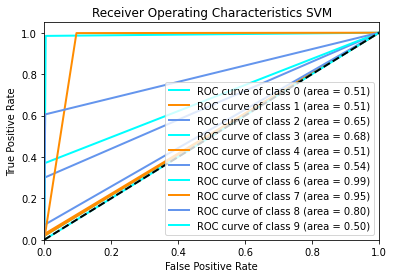

TRAIN: [     1      3      5 ... 249736 249737 249740] 
 TEST: [     0      2      4 ... 249738 249739 249741] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 0  3  4  5  6  7  8 10] 

shape pred 
 (49949, 8) 

shape test 
 (49949, 11) 

ROC SCORE:
 0.5221584717231714 

F1 SCORE:
 0.9774369857254399 

n_classes 8
fpr[i]  [0.0000000e+00 1.7699115e-04 1.0000000e+00]
tpr[i]  [0.0000000e+00 2.2573873e-05 1.0000000e+00]


<Figure size 432x288 with 0 Axes>

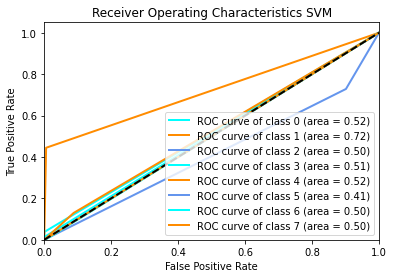

TRAIN: [     0      1      2 ... 249739 249740 249741] 
 TEST: [     3      7     11 ... 249707 249719 249735] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 1  2  3  4  5  6  7  8 10] 

shape pred 
 (49948, 9) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.4604092579230603 

F1 SCORE:
 0.977196284135501 

n_classes 9
fpr[i]  [0.00000000e+00 4.02754843e-05 1.00000000e+00]
tpr[i]  [0.         0.01034483 1.        ]


<Figure size 432x288 with 0 Axes>

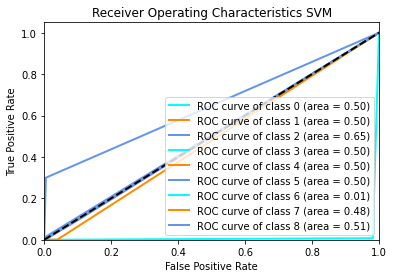

TRAIN: [     0      1      2 ... 249739 249740 249741] 
 TEST: [     9     17     23 ... 249716 249717 249728] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [0 2 3 4 5 6 7 8] 

shape pred 
 (49948, 8) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.46907136500355295 

F1 SCORE:
 0.9784976375430448 

n_classes 8
fpr[i]  [0.         0.05186759 1.        ]
tpr[i]  [0.00000000e+00 8.12659428e-04 1.00000000e+00]


<Figure size 432x288 with 0 Axes>

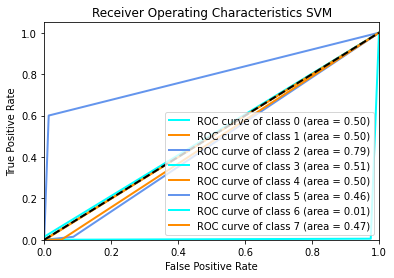

TRAIN: [     0      1      2 ... 249738 249739 249741] 
 TEST: [     5      6     21 ... 249727 249732 249740] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [0 1 2 3 4 5 6 7 8] 

shape pred 
 (49948, 9) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.7102917708687561 

F1 SCORE:
 0.9766757427724834 

n_classes 9
fpr[i]  [0.         0.00245676 1.        ]
tpr[i]  [0.         0.66782007 1.        ]


<Figure size 432x288 with 0 Axes>

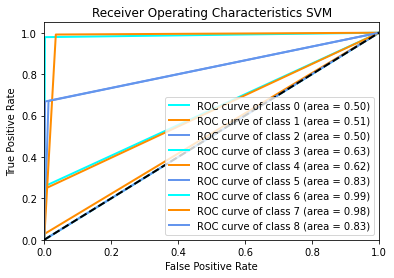

F1 score for SVM model prediction:  
 [0.9777172716170494, 0.9774369857254399, 0.977196284135501, 0.9784976375430448, 0.9766757427724834] 

Avg F1 score 0.9841396295014541 

Accuracy score for SVM prediction:  
 [] 

Avg cv score 0.6135627932954177 

Time taken by SVM model:  3.8552872000000207 seconds 



<Figure size 432x288 with 0 Axes>

In [58]:

skf = StratifiedKFold(n_splits=5,shuffle = True)
#   Training Model with SVM and evluate with F1 and ROC metrics:


time_svm =[]
f1_svm = []
roc_svm = []


for train_index, test_index in skf.split(X, y):
    count = 0
    print("TRAIN:", train_index,'\n', "TEST:", test_index,'\n')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Y_train:",np.unique(y_train),'\n')
    print("Y_test unique: ",np.unique(y_test),'\n')
    s = time.process_time()
    svm_model =  SGDClassifier( loss = 'hinge' ,alpha= 1e-5,penalty = 'l1')
    svm_model.fit(X_train,y_train)

    y_pred = svm_model.predict(X_test)
    print('ypred unique \n',np.unique(y_pred),'\n')
    e = time.process_time() - s
    time_svm.append(e)
    lb = preprocessing.LabelBinarizer()
    y_testsv = lb.fit_transform(y_test)
    y_predsv = lb.fit_transform(y_pred)

    print('shape pred \n',y_predsv.shape,'\n')
    print('shape test \n',y_testsv.shape,'\n')

    roc_score = roc_auc_score(y_testsv,y_predsv)
    print('ROC SCORE:\n',roc_score,'\n') 
    roc_knn.append(roc_score)

    f1score = f1_score(y_test, y_pred, average='micro')
    print('F1 SCORE:\n',f1score,'\n')
    f1_svm.append(f1score)

    plot_roc(y_pred, y_testsv, y_predsv, "SVM",count)
    count+=1

f1_svm_avg = np.mean(f1_knn)
roc_svm_avg = np.mean(roc_knn)
print("F1 score for SVM model prediction: ",'\n',f1_svm,'\n')
print("Avg F1 score",f1_svm_avg,'\n')
print("Accuracy score for SVM prediction: ",'\n',roc_svm,'\n')
print("Avg cv score",roc_svm_avg,'\n')
print("Time taken by SVM model: ", (sum(time_svm)/5),"seconds \n")
      

### Ensemble modeling

In [59]:
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
# Initializing all the 3 classifiers with best found parameters


knn_clf = KNeighborsClassifier( metric = 'manhattan', n_neighbors=11, weights= 'uniform')

nb_clf = GaussianNB(priors=None, var_smoothing = 0.2848035868435802)




TRAIN: [     0      1      2 ... 249739 249740 249741] 
 TEST: [     5      8     10 ... 249730 249732 249738] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 2  3  4  5  6  7  8  9 10] 

shape pred 
 (49949, 9) 

shape test 
 (49949, 11) 

ROC SCORE:
 0.46408171691896044 

F1 SCORE:
 0.9730324931430059 

n_classes 9
fpr[i]  [0.00000000e+00 2.41643174e-04 1.00000000e+00]
tpr[i]  [0. 0. 1.]


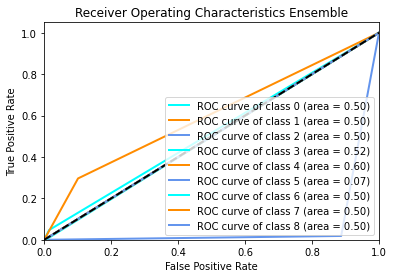

TRAIN: [     0      1      3 ... 249739 249740 249741] 
 TEST: [     2      6     13 ... 249729 249735 249736] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 2  3  4  5  6  7  8  9 10] 

shape pred 
 (49949, 9) 

shape test 
 (49949, 11) 

ROC SCORE:
 0.47964780766506515 

F1 SCORE:
 0.9729924523013473 

n_classes 9
fpr[i]  [0.00000000e+00 3.42334723e-04 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

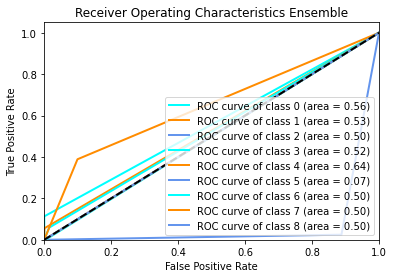

TRAIN: [     0      1      2 ... 249739 249740 249741] 
 TEST: [     4      9     14 ... 249717 249722 249723] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 2  3  4  5  6  7  8  9 10] 

shape pred 
 (49948, 9) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.4747269319203432 

F1 SCORE:
 0.9730319532313606 

n_classes 9
fpr[i]  [0.00000000e+00 2.01377422e-04 1.00000000e+00]
tpr[i]  [0. 0. 1.]


<Figure size 432x288 with 0 Axes>

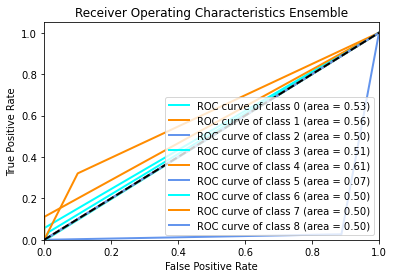

TRAIN: [     0      2      4 ... 249738 249740 249741] 
 TEST: [     1      3      7 ... 249734 249737 249739] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 2  3  4  5  6  7  8 10] 

shape pred 
 (49948, 8) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.46358771906876745 

F1 SCORE:
 0.9720509329702892 

n_classes 8
fpr[i]  [0.         0.00885112 1.        ]
tpr[i]  [0.0000000e+00 6.7721619e-05 1.0000000e+00]


<Figure size 432x288 with 0 Axes>

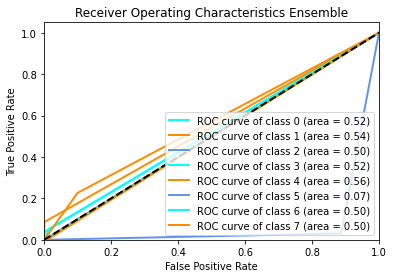

TRAIN: [     1      2      3 ... 249737 249738 249739] 
 TEST: [     0     11     12 ... 249731 249740 249741] 

Y_train: [ 0  1  2  3  4  5  6  7  8  9 10] 

Y_test unique:  [ 0  1  2  3  4  5  6  7  8  9 10] 

ypred unique 
 [ 2  3  4  5  6  7  8  9 10] 

shape pred 
 (49948, 9) 

shape test 
 (49948, 11) 

ROC SCORE:
 0.473125365148283 

F1 SCORE:
 0.9721910787218707 

n_classes 9
fpr[i]  [0.         0.00120824 1.        ]
tpr[i]  [0.        0.0449827 1.       ]


<Figure size 432x288 with 0 Axes>

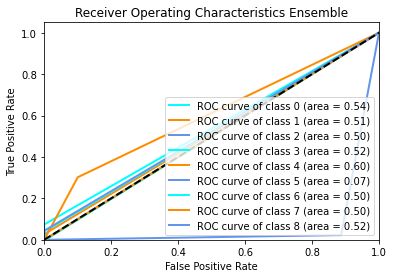

F1 score for ENSEMBLE model prediction:  
 [0.9730324931430059, 0.9729924523013473, 0.9730319532313606, 0.9720509329702892, 0.9721910787218707] 

Avg F1 score 0.9726597820735747 

Accuracy score for  ENSEMBLE prediction:  
 [0.46408171691896044, 0.47964780766506515, 0.4747269319203432, 0.46358771906876745, 0.473125365148283] 

Avg cv score 0.47103390814428386 

Time taken by ENSEMBLE model:  61.22729220000001 seconds 



<Figure size 432x288 with 0 Axes>

In [60]:

skf = StratifiedKFold(n_splits=5,shuffle = True)
#   Training Model with Ensemble and evluate with F1 and ROC metrics:


time_v =[]
f1_v = []
roc_v = []


for train_index, test_index in skf.split(X, y):
    count = 0
    print("TRAIN:", train_index,'\n', "TEST:", test_index,'\n')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Y_train:",np.unique(y_train),'\n')
    print("Y_test unique: ",np.unique(y_test),'\n')
    s = time.process_time()
    v_model =  VotingClassifier(estimators=[('knn', knn_clf),('nb', nb_clf)], voting='soft', n_jobs=-1)
    v_model.fit(X_train,y_train)

    y_pred = v_model.predict(X_test)
    print('ypred unique \n',np.unique(y_pred),'\n')
    e = time.process_time() - s
    time_v.append(e)
    lb = preprocessing.LabelBinarizer()
    y_testlb = lb.fit_transform(y_test)
    y_predlb = lb.fit_transform(y_pred)

    print('shape pred \n',y_predlb.shape,'\n')
    print('shape test \n',y_testlb.shape,'\n')

    roc_score = roc_auc_score(y_testlb,y_predlb)
    print('ROC SCORE:\n',roc_score,'\n') 
    roc_v.append(roc_score)

    f1score = f1_score(y_test, y_pred, average='micro')
    print('F1 SCORE:\n',f1score,'\n')
    f1_v.append(f1score)

    plot_roc(y_pred, y_testlb, y_predlb, "Ensemble",count)
    count+=1

f1_v_avg = np.mean(f1_v)
roc_v_avg = np.mean(roc_v)
print("F1 score for ENSEMBLE model prediction: ",'\n',f1_v,'\n')
print("Avg F1 score",f1_v_avg,'\n')
print("Accuracy score for  ENSEMBLE prediction: ",'\n',roc_v,'\n')
print("Avg cv score",roc_v_avg,'\n')
print("Time taken by ENSEMBLE model: ", (sum(time_v)/5),"seconds \n")
      

In [61]:
f1 = []
f1.append(f1_knn)
f1.append(f1_nv)

f1.append(f1_log)
f1.append(f1_svm)
f1.append(f1_v)

time_ = []
time_.append(time_knn)
time_.append(time_nv)

time_.append(time_log)
time_.append(time_svm)
time_.append(time_v)

roc = []
roc.append(roc_knn)
roc.append(roc_nv)

roc.append(roc_log)
roc.append(roc_svm)
roc.append(roc_v)

In [66]:
import matplotlib
def plot_metrics(title_,list_,l1,l2,l3,l4,l5):
    matplotlib.rc('figure', figsize=(10, 5))

    plt.title(title_)
    plt.plot(list_[0],'y',list_[1], 'r',list_[2],'g' ,list_[3],'b',list_[4],'c', markersize=15)
    [a,b,c,d,e] = plt.plot(list_[0],'yo',list_[1], 'ro',list_[2],'go',list_[3],'bo',list_[4],'co',markersize=10)
    plt.legend([a,b,c,d,e], [l1,l2,l3,l4,l5], loc=8,prop={'size': 12})
    plt.show()

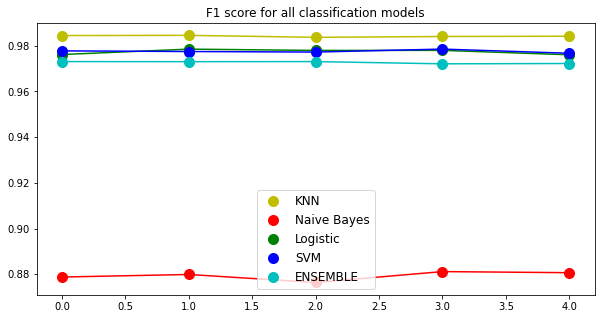

In [67]:
plot_metrics("F1 score for all classification models",f1,"KNN","Naive Bayes","Logistic","SVM","ENSEMBLE")



print()

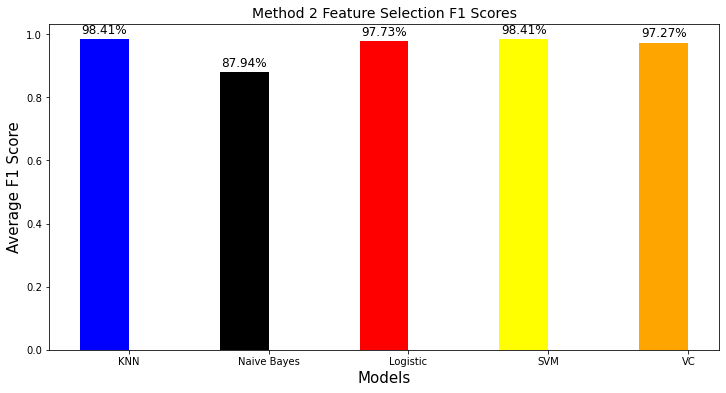

In [64]:

from matplotlib import pyplot as plt
import numpy as np

Models = ['KNN','Naive Bayes','Logistic','SVM', 'VC']
F1Score = [f1_knn_avg , f1_nv_avg,f1_log_avg, f1_svm_avg,f1_v_avg]



from matplotlib import pyplot as plt
import numpy as np


x = np.arange(len(Models)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Models',fontsize=15)
ax.set_ylabel('Average F1 Score',fontsize=15)
ax.set_title('Method 2 Feature Selection F1 Scores', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(Models)

pps = ax.bar(x - width/2, F1Score, width,align='center', label='F1Score',color = ['blue', 'black', 'red', 'yellow', 'orange', 'green'])
for p in pps:
   height = p.get_height()
   ax.annotate('{:.2%}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points", 
      ha='center', va='bottom', fontsize=12)

plt.show()



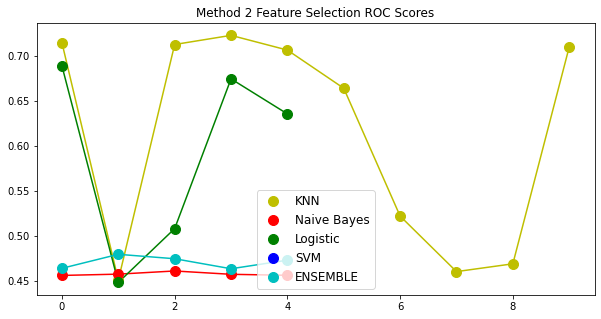

In [68]:
plot_metrics("Method 2 Feature Selection ROC Scores",roc,"KNN","Naive Bayes","Logistic","SVM","ENSEMBLE")

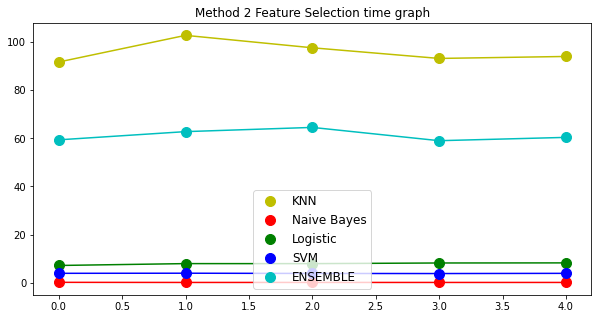

In [72]:
plot_metrics("Method 2 Feature Selection time graph",time_ ,"KNN","Naive Bayes","Logistic","SVM","ENSEMBLE")

In [69]:
knn_time_avg = (sum(time_knn)/5)
lr_time_avg = (sum(time_log)/5)

nb_time_avg = (sum(time_nv)/5)

svm_time_avg = (sum(time_svm)/5)
v_time_avg = (sum(time_v)/5)

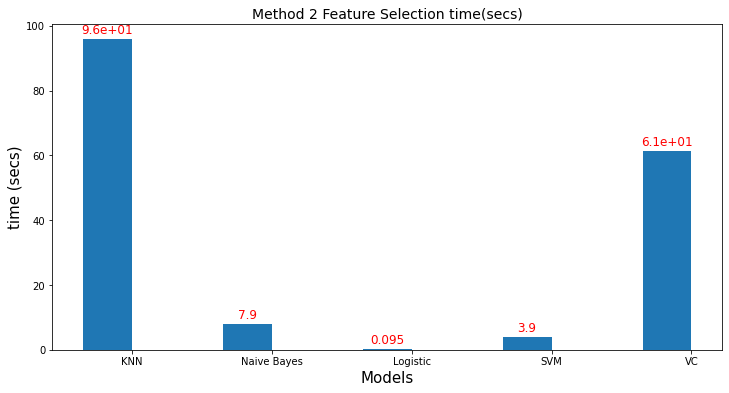

In [70]:

from matplotlib import pyplot as plt
import numpy as np

Models = ['KNN','Naive Bayes','Logistic','SVM', 'VC']
F1Score =  [knn_time_avg,lr_time_avg, nb_time_avg,svm_time_avg,v_time_avg]

x = np.arange(len(Models)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Models',fontsize=15)
ax.set_ylabel('time (secs)',fontsize=15)
ax.set_title('Method 2 Feature Selection time(secs)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(Models)

pps = ax.bar(x - width/2, F1Score, width,align='center', label='F1Score')
for p in pps:
   height = p.get_height()
   ax.annotate('{:.2}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points", 
      ha='center', va='bottom', fontsize=12,color = 'red')

plt.show()
           
           
           

### Show as a Dataframe

In [73]:
# An empty dictionary to store the result of all the models
result_dict = {"name":[], "auc":[], "f1":[]}

# Saving result of KNN
result_dict['name'].append("KNN")
result_dict['auc'].append(roc_knn_avg)
result_dict['f1'].append(f1_knn_avg )


# Saving result of log
result_dict['name'].append("LOG")
result_dict['auc'].append(roc_log_avg)
result_dict['f1'].append(f1_log_avg )


# Saving result of NB
result_dict['name'].append("NB")
result_dict['auc'].append(roc_nv_avg )
result_dict['f1'].append(f1_nv_avg)


# Saving result of SVM
result_dict['name'].append("SVM")
result_dict['auc'].append(roc_svm_avg)
result_dict['f1'].append(f1_svm_avg)




# Saving result of Ensemble
result_dict['name'].append("ENSEMBLE")
result_dict['auc'].append(roc_v_avg)
result_dict['f1'].append(f1_v_avg)




In [74]:
pd.DataFrame(result_dict)

,name,auc,f1
0,KNN,0.661859,0.984140
1,LOG,0.591317,0.977293
2,NB,0.457710,0.879404
3,SVM,0.613563,0.984140
4,ENSEMBLE,0.471034,0.972660
